In [2]:
import librosa
import pandas as pd
from librosa.effects import pitch_shift
import os
from sklearn.metrics import classification_report
import pathlib
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc, melspectrogram
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from research.dataImporting import MLtools
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, Conv2D, SeparableConv1D, MaxPooling1D,MaxPooling2D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation, LSTM, Lambda, Reshape, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from research.dataImporting import dataTools
import keras.backend as K

# Import data

In [3]:
training_df_raw=pd.read_csv("0.5s_raw_range_A1_A2_A3_no_overlap.csv")
training_df=pd.read_csv("0.5s_spec_range_A1_A2_A3_no_overlap.csv")

#  Range Estimation dataset creation

In [ ]:
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29" "Phone_3-1","Phone_3-2","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
bad_runs=["A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"]
good_runs_IF=["A1R1P1","A1R1P2","A1R1P3","A1R1P4","A1R1P5","A2R1P1","A2R1P2","A2R1P3","A2R1P4","A2R1P5","A2R2P1","A2R2P2","A2R2P3","A2R2P4","A2R2P5"]
good_runs_matrice=["A1R2P2","A1R2P3","A1R2P4","A1R2P5","A2R3P1","A2R3P2","A2R4P1","A2R4P2","A2R4P3","A3R3P1","A3R3P2","A3R4P2","A3R4P3","A3R4P5"]
test_runs_matrice=["A2R3P3","A3R3P3"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_A3_flight_directory.csv")
x_data=[]
y_data=[]
def rangeFraction(ranges): #Function normalizes ranges
    closest=np.min(ranges)
    return closest*1/ranges
def rangeClosest(ranges): #Function normalizes ranges
    ranges_copy=ranges
    truth=np.zeros(len(ranges))
    #for x in range(0, 2):
    closest=np.argmin(ranges_copy)
    ranges_copy[closest]=10000
    truth[closest]=1
    return truth
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df.loc[training_df[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    if full_name in good_runs_matrice:
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
        # frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
        #frame_df=pass_df.loc[pass_df["Segment"]==i]
            twd_frame=[]
            range_frame=[]
        #for phone in phone_slots:
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
            # phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
            #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                data=np.array(frame_df.iloc[:,-256:])
            #data=np.array(frame_df.iloc[:,-512:])
            # dist=phone_seg[str(notable_col_names.index('Range'))]
                dist=frame_df[str(notable_col_names.index('Range'))]
            #dist=phone_seg["Range"]
                if len(np.array(dist)>0):
                    if np.array(dist)[0]<100:
                        data=data[0]
                        data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                        dist=np.array(dist)[0]
                        twd_frame.append(data)
                        range_frame.append(dist)
            #y_vals= rangeClosest(range_frame)
            x_data.extend(np.array(twd_frame))
            y_data.extend(np.array(range_frame))

In [ ]:
x_data=np.array(x_data)
#x_data=np.transpose(x_data,axes=[0,2,1])
y_data=np.array(y_data)
train_feats,test_feats,train_targs,test_targs=train_test_split(x_data,y_data,test_size=0.2,shuffle=True)
input_shape=(4,64,1)

In [ ]:
def subsample(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=5,size=1)
        if y_data[x]==3 and rand_vals==2:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x] != 3:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)

# Classification Dataset Creation

In [73]:
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29" "Phone_3-1","Phone_3-2","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
bad_runs=["A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"]
good_runs_IF=["A1R1P1","A1R1P2","A1R1P3","A1R1P4","A1R1P5","A2R1P1","A2R1P2","A2R1P3","A2R1P4","A2R1P5","A2R2P1","A2R2P2","A2R2P3","A2R2P4","A2R2P5"]
good_runs_matrice=["A1R2P2","A1R2P3","A1R2P4","A1R2P5","A2R3P1","A2R3P2","A2R4P1","A2R4P2","A2R4P3","A3R3P1","A3R3P2","A3R4P2","A3R4P3","A3R4P5"]
test_runs_matrice=["A2R3P3","A3R3P3"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_A3_flight_directory.csv")
x_data=[]
y_data=[]
def rangeFraction(ranges): #Function normalizes ranges
    closest=np.min(ranges)
    return closest*1/ranges

def classFinder(distance):
    if distance<=40 :
        class_val=0
    elif distance<=60:
        class_val=1
    elif distance<=80:
        class_val=2
    elif distance>80:
        class_val=3

    return class_val

def classFinderv2(distance):
    if distance<30:
        class_val=0
    elif distance<=40:
        class_val=1
    elif distance<=50:
        class_val=2
    elif distance<=60:
        class_val=3
    elif distance<=70:
        class_val=4
    elif distance<=80:
        class_val=5
    else:
        class_val=6
    return class_val
def rangeClosest(ranges): #Function normalizes ranges
    ranges_copy=ranges
    truth=np.zeros(len(ranges))
    #for x in range(0, 2):
    closest=np.argmin(ranges_copy)
    ranges_copy[closest]=10000
    truth[closest]=1
    return truth
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df.loc[training_df[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    if full_name in good_runs_matrice:
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
        # frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
        #frame_df=pass_df.loc[pass_df["Segment"]==i]
            twd_frame=[]
            range_frame=[]
        #for phone in phone_slots:
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
            # phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
            #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                data=np.array(frame_df.iloc[:,-256:])
            #data=np.array(frame_df.iloc[:,-512:])
            # dist=phone_seg[str(notable_col_names.index('Range'))]
                dist=frame_df[str(notable_col_names.index('Range'))]
            #dist=phone_seg["Range"]
                if len(np.array(dist)>0):
                    #if np.array(dist)[0]<100:
                    data=data[0]
                    data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                    dist=np.array(dist)[0]
                    class_value=classFinder(dist)
                    twd_frame.append(data)
                    range_frame.append(class_value)
            #y_vals= rangeClosest(range_frame)
            x_data.extend(np.array(twd_frame))
            y_data.extend(np.array(range_frame))

A1R1P1
A1R1P2
A1R1P3
A1R1P4
A1R1P5
A1R2P1
A1R2P2



KeyboardInterrupt



# Classification with raw data

In [5]:
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29" "Phone_3-1","Phone_3-2","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
bad_runs=["A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"]
good_runs_IF=["A1R1P1","A1R1P2","A1R1P3","A1R1P4","A1R1P5","A2R1P1","A2R1P2","A2R1P3","A2R1P4","A2R1P5","A2R2P1","A2R2P2","A2R2P3","A2R2P4","A2R2P5"]
good_runs_matrice=["A1R2P2","A1R2P3","A1R2P4","A1R2P5","A2R3P1","A2R3P2","A2R4P1","A2R4P2","A2R4P3","A3R3P1","A3R3P2","A3R4P2","A3R4P3","A3R4P5"]
good_runs_phantom=["A2R5P1","A2R5P2","A2R5P3","A2R5P4","A2R5P5","A2R6P1","A2R6P2","A2R6P3","A2R6P4","A2R6P5","A3R5P1","A3R5P2","A3R5P3","A3R5P4","A3R6P1","A3R6P2","A3R6P3","A3R6P4"]
test_runs_matrice=["A2R3P3","A3R3P3"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_A3_flight_directory.csv")
x_data=[]
y_data=[]
def rangeFraction(ranges): #Function normalizes ranges
    closest=np.min(ranges)
    return closest*1/ranges

def classFinder(distance):
    if distance<=40 :
        class_val=0
    elif distance<=60:
        class_val=1
    elif distance<=80:
        class_val=2
    else:
        class_val=3
    return class_val

def rangeClosest(ranges): #Function normalizes ranges
    ranges_copy=ranges
    truth=np.zeros(len(ranges))
    #for x in range(0, 2):
    closest=np.argmin(ranges_copy)
    ranges_copy[closest]=10000
    truth[closest]=1
    return truth
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df_raw.loc[training_df_raw[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    if full_name in good_runs_matrice:
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
        # frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
        #frame_df=pass_df.loc[pass_df["Segment"]==i]
            twd_frame=[]
            range_frame=[]
        #for phone in phone_slots:
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
            # phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
            #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                data=np.array(frame_df.iloc[:,8:4008])
            #data=np.array(frame_df.iloc[:,-512:])
            # dist=phone_seg[str(notable_col_names.index('Range'))]
                dist=frame_df[str(notable_col_names.index('Range'))]
            #dist=phone_seg["Range"]
                if len(np.array(dist)>0):
                    if np.array(dist)[0]<100:
                        data=data[0]
                        #data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                        dist=np.array(dist)[0]
                        class_value=classFinder(dist)
                        twd_frame.append(data)
                        range_frame.append(class_value)
            #y_vals= rangeClosest(range_frame)
            x_data.extend(np.array(twd_frame))
            y_data.extend(np.array(range_frame))

A1R1P1
A1R1P2
A1R1P3
A1R1P4
A1R1P5
A1R2P1
A1R2P2



KeyboardInterrupt



# From raw to actual data

In [113]:
def melspect(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    data= audioData.astype(float)
    # spect = melspectrogram(y=data,sr=Fs, hop_length=1024,n_mels=64, n_fft=2048)
    spect = melspectrogram(y=data,sr=Fs)
    return spect
x_data=[]
y_data=[]
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df_raw.loc[training_df_raw[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    if full_name in good_runs_IF:
        drone_type=1
    elif full_name in good_runs_matrice:
        drone_type=0
    else:
        drone_type=2
    #if full_name in good_runs_matrice or full_name in good_runs_IF or full_name in good_runs_phantom:
    if full_name in good_runs_matrice:
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
        # frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
        #frame_df=pass_df.loc[pass_df["Segment"]==i]
            twd_frame=[]
            range_frame=[]
        #for phone in phone_slots:
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
            # phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
            #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                data=np.array(frame_df.iloc[:,8:4008])
                if np.any(data):
                    mel_data=melspect(data[0],8000)
            #data=np.array(frame_df.iloc[:,-512:])
            # dist=phone_seg[str(notable_col_names.index('Range'))]
                dist=frame_df[str(notable_col_names.index('Range'))]
            #dist=phone_seg["Range"]
                if len(np.array(dist)>0):
                    if np.array(dist)[0]<250:
                        data=data[0]
                        #data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                        dist=np.array(dist)[0]
                        class_value=classFinder(dist)
                        twd_frame.append(mel_data)
                        range_frame.append([class_value,drone_type,dist])
            #y_vals= rangeClosest(range_frame)
            x_data.extend(np.array(twd_frame))
            y_data.extend(np.array(range_frame))

A1R1P1
A1R1P2
A1R1P3
A1R1P4
A1R1P5
A1R2P1
A1R2P2
A1R2P3
A1R2P4
A1R2P5
A2R1P1
A2R1P2
A2R1P3
A2R1P4
A2R1P5
A2R2P1
A2R2P2
A2R2P3
A2R2P4
A2R2P5
A2R3P1
A2R3P2
A2R3P3
A2R4P1
A2R4P2
A2R4P3
A2R5P1
A2R5P2
A2R5P3
A2R5P4
A2R5P5
A2R6P1
A2R6P2
A2R6P3
A2R6P4
A2R6P5
A2R7P1
A2R7P2
A2R7P3
A2R7P4
A2R7P5
A2R8P1
A2R8P2
A2R8P3
A2R8P4
A2R8P5
A3R3P1
A3R3P2
A3R3P3
A3R3P4
A3R3P5
A3R4P1
A3R4P2
A3R4P3
A3R4P4
A3R4P5
A3R5P1
A3R5P2
A3R5P3
A3R5P4
A3R6P1
A3R6P2
A3R6P3
A3R6P4


In [102]:
def subsample(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=7,size=1)
        if y_data[x][0]==3 and rand_vals[0]==2:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x][0] != 3:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)
x_data=np.array(x_data)
x_data=np.float32(x_data)
#x_data=np.transpose(x_data,axes=[0,2,1])
y_data=np.array(y_data)
x__,y__=subsample(x_data,y_data)
train_feats,test_feats,train_targs,test_targs=train_test_split(x__,y__,test_size=0.2,shuffle=True)
class_train_targs=train_targs[:,1]
cont_range_train_targs=train_targs[:,2]
range_train_targs=train_targs[:,0]
class_train_targs_oh=tf.keras.utils.to_categorical(class_train_targs,num_classes=3)
range_train_targs_oh=tf.keras.utils.to_categorical(range_train_targs,num_classes=4)
class_test_targs=test_targs[:,1]
cont_range_test_targs=test_targs[:,2]
range_test_targs=test_targs[:,0]
class_test_targs_oh=tf.keras.utils.to_categorical(class_test_targs,num_classes=3)
range_test_targs_oh=tf.keras.utils.to_categorical(range_test_targs,num_classes=4)

(array([ 563., 2593.,    0.,  381.,    0.,  940., 1680.,    0.,  651.,
        1604.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

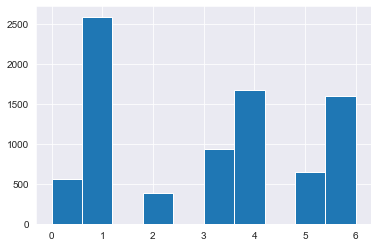

In [103]:
plt.hist(range_train_targs)

In [105]:
from sklearn.utils import class_weight
# class_weights=class_weight.compute_class_weight('balanced', classes=np.unique(class_train_targs), y=class_train_targs)
# class_weights={0:class_weights[0], 1:class_weights[1]}
#print(class_weights)
range_weights=class_weight.compute_class_weight('balanced', classes=np.unique(range_train_targs), y=range_train_targs)
range_weights={0:range_weights[0], 1:range_weights[1],2:range_weights[2], 3:range_weights[3],4:range_weights[4],5:range_weights[5], 6:range_weights[6]}
print(range_weights)

{0: 2.134483633595534, 1: 0.4634455401906231, 2: 3.154105736782902, 3: 1.2784194528875379, 4: 0.7153061224489796, 5: 1.8459512837393022, 6: 0.749198432490203}


In [ ]:
import librosa.display
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(x_data[1], ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=8000,
                         fmax=4000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

# Multiclass Clasification with multiple outputs

In [48]:
# modelCNN=tf.keras.Sequential()
# modelCNN.add(BatchNormalization(input_shape=(128,8,1)))
# modelCNN.add(Conv2D(filters=32,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
# modelCNN.add(BatchNormalization())
# modelCNN.add(Activation('relu'))
# modelCNN.add(MaxPooling2D(2,2))
# modelCNN.add(Conv2D(filters=32,kernel_size=(4,4),strides=(2,2), use_bias=False,
#                          padding='SAME', name='conv_2'))
# modelCNN.add(BatchNormalization())
# modelCNN.add(Activation('relu'))
# modelCNN.add(Dropout(0.3))
# modelCNN.add(Conv2D(filters=32,kernel_size=(4,4),strides=(4,4), use_bias=False,
#                          padding='SAME', name='conv_3'))
# modelCNN.add(BatchNormalization())
# modelCNN.add(Activation('relu'))
# modelCNN.add(Dropout(0.3))
# modelCNN.add(Flatten())
# modelCNN.add(Dense(512, activation='relu', name='dense_2'))
# modelCNN.add(Dense(256, activation='relu', name='dense_3'))
# modelCNN.add(Dropout(0.5))
# modelCNN.add(Dense(4, activation='softmax', name='dense_4'))
#modelCNN=tf.keras.Functional()
inputs= Input(shape=(128,8,1),name='input')
hidden=BatchNormalization(input_shape=(128,8,1))(inputs)
hidden=Conv2D(filters=32,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1')(hidden)
hidden=BatchNormalization()(hidden)
hidden=Activation('relu')(hidden)
hidden=MaxPooling2D(2,2)(hidden)
hidden=Conv2D(filters=32,kernel_size=(4,4),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_2')(hidden)
hidden=BatchNormalization()(hidden)
hidden=Activation('relu')(hidden)
hidden=Dropout(0.3)(hidden)
hidden=Conv2D(filters=32,kernel_size=(4,4),strides=(4,4), use_bias=False,
                         padding='SAME', name='conv_3')(hidden)
hidden=BatchNormalization()(hidden)
hidden=Activation('relu')(hidden)
hidden=Dropout(0.3)(hidden)
hidden=Flatten()(hidden)
hidden=Dense(512, activation='relu', name='dense_2')(hidden)
hidden=Dense(256, activation='relu', name='dense_3')(hidden)
hidden=Dropout(0.5)(hidden)
output1=Dense(4, activation='softmax', name='output_range')(hidden)
#output2=Dense(3,activation='softmax',name="output_class")(hidden)
output3=Dense(1,activation='linear',name="output_cont_range")(hidden)


modelCNN=Model(inputs=inputs,outputs=[output1,output3])
optimizer= tf.keras.optimizers.Adam()
modelCNN.compile(loss={'output_range':'categorical_crossentropy',
                       'output_cont_range':'mse'},optimizer=optimizer,metrics=['accuracy','mae'])


reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=20, mode='auto', restore_best_weights=True)
modelCNN.build(input_shape=(None,128,8,1))
modelCNN.summary()
history = modelCNN.fit(train_feats, {'output_range':range_train_targs_oh,'output_cont_range': cont_range_train_targs},
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      #class_weight={'output_1':range_weights,'output_2': class_weights},
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 128, 8, 1)]  0           []                               
                                                                                                  
 batch_normalization_52 (BatchN  (None, 128, 8, 1)   4           ['input[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 conv_1 (Conv2D)                (None, 128, 8, 32)   128         ['batch_normalization_52[0][0]'] 
                                                                                                  
 batch_normalization_53 (BatchN  (None, 128, 8, 32)  128         ['conv_1[0][0]']          

In [49]:
score = modelCNN.predict(test_feats)
modelCNN.evaluate(test_feats,y={'output_range':range_test_targs_oh,'output_cont_range':cont_range_test_targs})
test_predictions=modelCNN.predict(test_feats)

20/20 [==============================] - 0s 5ms/step


Text(0.5, 1.0, 'Refined Confusion Matrix')

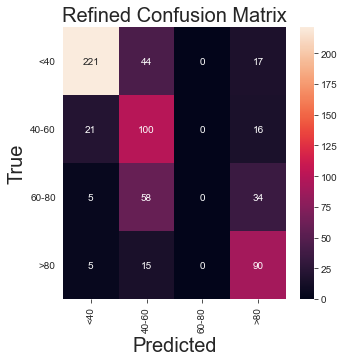

In [50]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(test_predictions[0],axis=-1)
y_true=np.argmax(range_test_targs_oh, axis=-1)
cm = confusion_matrix(y_true, y_pred)
## Get Class Labels
class_names = ["<40","40-60","60-80",">80"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

In [52]:
print(classification_report(y_true=y_true,y_pred=y_pred)) #this is using the multi-output regression/classification

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       282
           1       0.46      0.73      0.56       137
           2       0.00      0.00      0.00        97
           3       0.57      0.82      0.67       110

    accuracy                           0.66       626
   macro avg       0.48      0.58      0.52       626
weighted avg       0.60      0.66      0.61       626



C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rclendening\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

# Multiclass classification

In [107]:
modelCNN_MC=tf.keras.Sequential()
modelCNN_MC.add(BatchNormalization(input_shape=(128,8,1)))
modelCNN_MC.add(Conv2D(filters=32,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1'))
modelCNN_MC.add(BatchNormalization())
modelCNN_MC.add(Activation('relu'))
modelCNN_MC.add(MaxPooling2D(2,2))
modelCNN_MC.add(Conv2D(filters=32,kernel_size=(4,4),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCNN_MC.add(BatchNormalization())
modelCNN_MC.add(Activation('relu'))
modelCNN_MC.add(Dropout(0.3))
modelCNN_MC.add(Conv2D(filters=32,kernel_size=(4,4),strides=(4,4), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCNN_MC.add(BatchNormalization())
modelCNN_MC.add(Activation('relu'))
modelCNN_MC.add(Dropout(0.3))
modelCNN_MC.add(Flatten())
modelCNN_MC.add(Dense(512, activation='relu', name='dense_2'))
modelCNN_MC.add(Dense(256, activation='relu', name='dense_3'))
modelCNN_MC.add(Dropout(0.5))
modelCNN_MC.add(Dense(7, activation='softmax', name='output_range'))
# inputs= Input(shape=(128,8,1),name='input')
# hidden=BatchNormalization(input_shape=(128,8,1))(inputs)
# hidden=Conv2D(filters=32,kernel_size=(2,2),strides=(1,1),padding='SAME', use_bias=False, name='conv_1')(hidden)
# hidden=BatchNormalization()(hidden)
# hidden=Activation('relu')(hidden)
# hidden=MaxPooling2D(2,2)(hidden)
# hidden=Conv2D(filters=32,kernel_size=(4,4),strides=(2,2), use_bias=False,
#                          padding='SAME', name='conv_2')(hidden)
# hidden=BatchNormalization()(hidden)
# hidden=Activation('relu')(hidden)
# hidden=Dropout(0.3)(hidden)
# hidden=Conv2D(filters=32,kernel_size=(4,4),strides=(4,4), use_bias=False,
#                          padding='SAME', name='conv_3')(hidden)
# hidden=BatchNormalization()(hidden)
# hidden=Activation('relu')(hidden)
# hidden=Dropout(0.3)(hidden)
# hidden=Flatten()(hidden)
# hidden=Dense(512, activation='relu', name='dense_2')(hidden)
# hidden=Dense(256, activation='relu', name='dense_3')(hidden)
# hidden=Dropout(0.5)(hidden)
# output1=Dense(7, activation='softmax', name='output_range')(hidden)
#output2=Dense(3,activation='softmax',name="output_class")(hidden)
#output3=Dense(1,activation='linear',name="output_cont_range")(hidden)


#modelCNNv2=Model(inputs=inputs,outputs=[output1])
optimizer= tf.keras.optimizers.Adam()
modelCNN_MC.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])


reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=20, mode='auto', restore_best_weights=True)
modelCNN_MC.build(input_shape=(None,128,8,1))
modelCNN_MC.summary()
history = modelCNN_MC.fit(train_feats, range_train_targs_oh,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      class_weight=range_weights,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_80 (Bat  (None, 128, 8, 1)        4         
 chNormalization)                                                
                                                                 
 conv_1 (Conv2D)             (None, 128, 8, 32)        128       
                                                                 
 batch_normalization_81 (Bat  (None, 128, 8, 32)       128       
 chNormalization)                                                
                                                                 
 activation_61 (Activation)  (None, 128, 8, 32)        0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 4, 32)        0         
 g2D)                                                            
                                                      

In [108]:
score = modelCNN_MC.predict(test_feats)
modelCNN_MC.evaluate(test_feats,y={'output_range':range_test_targs_oh})
test_predictions=modelCNN_MC.predict(test_feats)

66/66 [==============================] - 0s 6ms/step


Text(0.5, 1.0, 'Mavic Confusion Matrix')

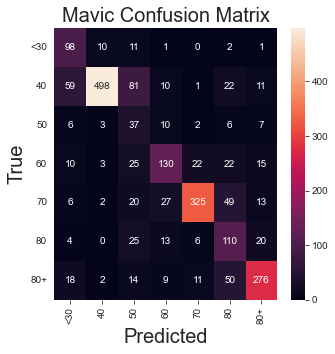

In [112]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(test_predictions,axis=-1)
y_true=np.argmax(range_test_targs_oh, axis=-1)
cm = confusion_matrix(y_true, y_pred)
## Get Class Labels
#class_names = ["<40","40-60","60-80",">80"]
class_names = ["<30", "40","50","60","70","80","80+"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Mavic Confusion Matrix', fontsize=20)

In [110]:
print(classification_report(y_true=y_true,y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.49      0.80      0.60       123
           1       0.96      0.73      0.83       682
           2       0.17      0.52      0.26        71
           3       0.65      0.57      0.61       227
           4       0.89      0.74      0.80       442
           5       0.42      0.62      0.50       178
           6       0.80      0.73      0.76       380

    accuracy                           0.70      2103
   macro avg       0.63      0.67      0.62      2103
weighted avg       0.78      0.70      0.73      2103



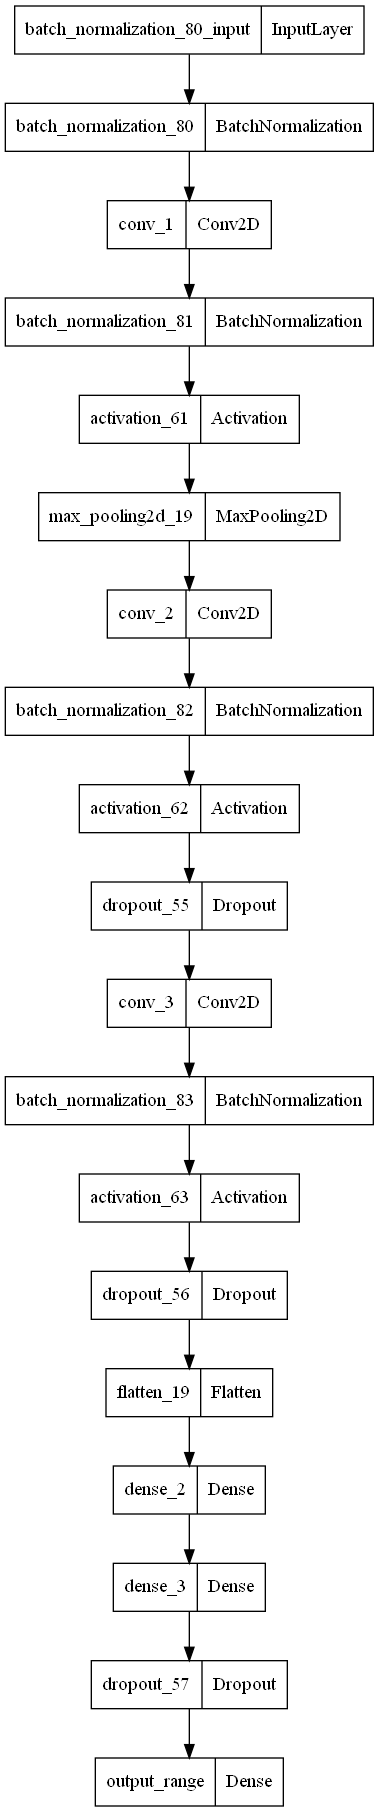

In [111]:
tf.keras.utils.plot_model(modelCNN_MC)

# Deep Recurrent Neural Network For Ranging
Those shouldn't work unless the data is laid out so that each phone's observation extends for 300 sequential frames, then switches to the next.

In [ ]:
modelCRNN=tf.keras.Sequential()
modelCRNN.add(BatchNormalization())
modelCRNN.add(Conv2D(filters=8, kernel_size=(2,2), strides=(1,1), padding='SAME', use_bias=False,input_shape=(128,8,1), name='conv_1'))
modelCRNN.add(BatchNormalization())
modelCRNN.add(Activation('leaky_relu'))
modelCRNN.add(Conv2D(filters=16,kernel_size=(4,4),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_2'))
modelCRNN.add(BatchNormalization())
modelCRNN.add(Activation('leaky_relu'))
# model.add(MaxPooling2D(padding='SAME'))
modelCRNN.add(Conv2D(filters=32,kernel_size=(4,4),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_3'))
modelCRNN.add(BatchNormalization())
modelCRNN.add(Activation('leaky_relu'))
modelCRNN.add(Conv2D(filters=64,kernel_size=(4,4),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_4'))
modelCRNN.add(BatchNormalization())
modelCRNN.add(Activation('leaky_relu'))
# model.add(Conv2D(filters=32,kernel_size=(8,8),strides=(1,1), use_bias=False,
#                          padding='SAME', name='conv_4'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
modelCRNN.add(Dropout(0.5))
modelCRNN.add(Flatten())
modelCRNN.add(Reshape((-1,1024),input_shape=(1024,)))
modelCRNN.add(GRU(64))
#modelCRNN.add(Dense(1024, activation='relu', name='dense_2'))
#model.add(Lambda(lambda x: K.squeeze(x, 1)))
#model.add(LSTM(16))
modelCRNN.add(Dense(64, activation='relu', name='dense_3'))
modelCRNN.add(Dropout(0.5))
modelCRNN.add(Dense(4, activation='softmax', name='dense_4'))


optimizer= tf.keras.optimizers.Adam()
modelCRNN.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3,
                          patience=40, mode='auto', restore_best_weights=True)
modelCRNN.build(input_shape=(None,128,8,1))
modelCRNN.summary()
history = modelCRNN.fit(train_feats, train_targs,
                      epochs=200,
                      batch_size=32,
                      class_weight=class_weights,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

In [ ]:
score = modelCRNN.predict(test_feats)
modelCRNN.evaluate(test_feats,test_targs)
test_predictions=modelCRNN.predict(test_feats)

In [ ]:
y_pred = np.argmax(test_predictions, axis=-1)
y_true=np.argmax(test_targs, axis=-1)
cm = confusion_matrix(y_true, y_pred)
## Get Class Labels
class_names = ["<40","40-60","60-80",">80"]
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=20)

In [ ]:

print(classification_report(y_true=y_true,y_pred=y_pred))

In [ ]:
plt.hist(y_true,alpha=0.5)
plt.hist(y_pred,alpha=0.5)
plt.show()

In [ ]:
score=np.reshape(score,-1)
residual=score-test_targs
plt.xlabel("Truth (meters)")
plt.ylabel("Error (meters)")
plt.scatter(test_targs,np.abs(residual))
plt.show()

In [ ]:
resid_df=pd.DataFrame({"Actual":test_targs,"Error":residual})

In [ ]:
ave_error=[]
sub_40=resid_df[resid_df["Actual"]<40]
ave_error.append(sub_40["Error"].mean())
sub_40=resid_df[resid_df["Actual"]<60]
sub_40=sub_40[sub_40["Actual"]>40]
ave_error.append(sub_40["Error"].mean())
sub_40=resid_df[resid_df["Actual"]<80]
sub_40=sub_40[sub_40["Actual"]>60]
ave_error.append(sub_40["Error"].mean())
sub_40=resid_df[resid_df["Actual"]>80]
ave_error.append(sub_40["Error"].mean())

In [ ]:
print(ave_error)

In [ ]:
MLtools.save_model(model, "CRNN_model_v3_trainedon_A2A3_MAE18")

In [ ]:
plt.hist(train_targs)

# Deep Neural Network for Ranging
I think that the A3 data is incorrect, truth vals are incorrect, or combination. Training on A2 produces accurate results (atleast, expected, increased error as distance increases. Instead, A3 data has more have a V shaped error. I should investigate if certain phones are extremely accurate and if other phones are not as accurate.

In [ ]:
model=tf.keras.Sequential()
model.add(BatchNormalization(input_shape=(64,4,1)))
model.add(Conv2D(filters=8,kernel_size=(4,4),strides=(2,2),padding='SAME', use_bias=False, name='conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPooling2D())
model.add(Conv2D(filters=16,kernel_size=(4,4),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=32,kernel_size=(4,4),strides=(2,2), use_bias=False,
                         padding='SAME', name='conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1024, activation='relu', name='dense_2'))
model.add(Dense(512, activation='relu', name='dense_3'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear', name='dense_4'))


optimizer= tf.keras.optimizers.Adam()
model.compile(loss='mse',optimizer=optimizer,metrics=['mae','mse'])


reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=20, mode='auto', restore_best_weights=True)
model.build(input_shape=(None,64,4,1))
model.summary()
history = model.fit(train_feats, train_targs,
                      epochs=200,
                      batch_size=32,
                      shuffle=True,
                      class_weight=class_weights,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

In [ ]:
score = model.predict(test_feats)
model.evaluate(test_feats,test_targs)

In [ ]:
plt.hist(test_targs,alpha=0.5,label="Actual")
plt.hist(score,alpha=0.5,label="Predicted")
plt.xlabel('Truth Range')
plt.legend(loc="upper right")
plt.savefig('test_distribution.pdf')

In [ ]:
print(score)
print(len(test_targs))
score=np.reshape(score,-1)
residual=score-test_targs
print(np.shape(score))
print(np.shape(test_targs))
plt.xlabel("Truth (meters)")
plt.ylabel("Error (meters)")
plt.scatter(test_targs,np.abs(residual))
plt.show()
plt.xlabel("Truth (meters)")
plt.ylabel("Error (meters)")
plt.scatter(test_targs,residual)

In [ ]:
resid_df=pd.DataFrame({"Actual":test_targs,"Error":residual})
ave_error=[]
sub_40=resid_df[resid_df["Actual"]<40]
ave_error.append(sub_40["Error"].mean())
sub_40=resid_df[resid_df["Actual"]<60]
sub_40=sub_40[sub_40["Actual"]>40]
ave_error.append(sub_40["Error"].mean())
sub_40=resid_df[resid_df["Actual"]<80]
sub_40=sub_40[sub_40["Actual"]>60]
ave_error.append(sub_40["Error"].mean())
sub_40=resid_df[resid_df["Actual"]>80]
ave_error.append(sub_40["Error"].mean())
print(ave_error)

In [ ]:
plt.xlabel('Truth Range')
plt.ylabel('Error (MAE)')
plt.bar(x=(30,50,70,90),height=ave_error,width=20)
plt.savefig('plt.pdf')

In [ ]:
MLtools.save_model(model, "CNN_model_v1_generalizable")

# LSTM with Raw Inputs

In [ ]:
mean = train_feats.mean(axis=0)
train_feats -= mean
test_feats -= mean
std = train_feats.std(axis=0)
train_feats /= std
test_feats /= std
train_feats=np.reshape(train_feats, (len(train_feats), 4000, 1))
print(len(train_feats))

In [ ]:
modelRaw=tf.keras.Sequential()
modelRaw.add(Conv1D(2, kernel_size=100, padding = 'causal', activation = 'relu', name='Conv0', input_shape=(4000, 1)))
modelRaw.add(BatchNormalization())
modelRaw.add(Conv1D(2, kernel_size=100, padding = 'causal', dilation_rate=4, activation = 'relu', name='Conv1'))
modelRaw.add(BatchNormalization())
modelRaw.add(Conv1D(2, kernel_size=100, padding = 'causal',dilation_rate=16, activation = 'relu', name='Conv2'))
# modelRaw.add(BatchNormalization())
# modelRaw.add(Conv1D(2, kernel_size=6, padding = 'causal', dilation_rate=8, activation = 'relu', name='Conv3'))
# modelRaw.add(BatchNormalization())
# modelRaw.add(Conv1D(2, kernel_size=6, padding = 'causal', dilation_rate=16, activation = 'relu', name='Conv4'))
# modelRaw.add(BatchNormalization())
# modelRaw.add(Dropout(0.5))
# modelRaw.add(Conv1D(2, kernel_size=6, padding = 'causal', dilation_rate=32, activation = 'relu', name='Conv5'))
# modelRaw.add(BatchNormalization())
modelRaw.add(Dropout(0.5))
# modelRaw.add(Conv1D(2, kernel_size=6, padding = 'causal', dilation_rate=64, activation = 'relu', name='Conv6'))
modelRaw.add(Flatten())
modelRaw.add(Dense(4, activation='softmax', name='dense_1'))

optimizer= tf.keras.optimizers.Adam()
modelRaw.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])



reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=20, mode='auto', restore_best_weights=True)
modelRaw.build(input_shape=(None,4000,1))
modelRaw.summary()
history = modelRaw.fit(train_feats, train_targs,
                      epochs=200,
                      batch_size=16,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])

# Generate Test dataset and test target dataset

In [ ]:
#test_df=pd.read_csv("./spec_range_A3_testset.csv")
# test_df=training_df
# def maxValueRanks(maxValArray):
#     maxValueRankArr=[]
#     for x in maxValArray:
#         seq = sorted(x)
#         index = [seq.index(v) for v in x]
#         maxValueRankArr.append(index)
#     return maxValueRankArr
test_runs_matrice=["A2R3P2"]
def rank_distances(maxValArray):
    order=maxValArray.argsort()
    ranks=order.argsort()
    return ranks
def closest_distances(maxValArray):
    count=0
    for x in maxValArray:
        if x <40:
            count+=1
    return count
def eval_rangeModel_performance(truth_data):
    pure_x_data=[]
    pure_y_data=[]
    x_data=[]
    y_data=[]
    class_range_frame=[]
    for x in passes_df.iterrows():
        row=x[1]
        pass_num=row[0]
        scenario=row[1]
        run_num=row[2]
        start=row[3]
        stop=row[4]
        drone_gps_file=row[5]
        full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
        pass_df=training_df.loc[training_df[str(notable_col_names.index('Pass'))] == full_name]
        #pass_df=training_df.loc[training_df["Pass"] == full_name]
        max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
        #max_segment=pass_df["Segment"].max()
        #for i in range(0,max_segment):
        print(full_name)
        if full_name in test_runs_matrice:
            #for phone in phone_slots:
            for i in range(0,max_segment):
                #phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
                frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
            #frame_df=pass_df.loc[pass_df["Segment"]==i]
                twd_frame=[]
                range_frame=[]
                class_range_frame=[]
            #for phone in phone_slots:
                #for i in range(0,max_segment):
                for phone in phone_slots:
                    #frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
                    phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
                #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                    #data=np.array(frame_df.iloc[:,-256:])
                    data=np.array(phone_seg.iloc[:,-256:])
                # dist=phone_seg[str(notable_col_names.index('Range'))]
                    dist=phone_seg[str(notable_col_names.index('Range'))]
                #dist=phone_seg["Range"]
                    if len(np.array(dist)>0):
                        if np.array(dist)[0]<400:
                            data=data[0]
                            data=np.reshape(data,(64,4))
                            #data=np.reshape(data,(40,1))
                            dist=np.array(dist)[0]
                            twd_frame.append(data)
                            range_frame.append(dist)
                            class_value=classFinder(dist)
                            class_range_frame.append(class_value)
                ranks=closest_distances(np.array(range_frame))
                #y_vals= rangeClosest(range_frame)
                # if np.any(ranks):
                if ranks>0:
                    x_data.append(np.array(twd_frame))
                    y_data.append(np.array(class_range_frame))
                    pure_x_data.extend(np.array(twd_frame))
                    pure_y_data.extend(np.array(class_range_frame))
    return x_data,y_data,pure_x_data,pure_y_data

test_feats_,test_targs_,pure_x,pure_y=eval_rangeModel_performance(training_df)

In [ ]:
pure_x=np.array(pure_x)
#pure_x=np.transpose(pure_x,axes=[0,2,1])
#pure_x=np.array(pure_x).reshape(len(pure_x),4,64,1)
pure_y=np.array(pure_y)
pure_y_oh=tf.keras.utils.to_categorical(pure_y,num_classes=4)
plt.hist(pure_y)

In [ ]:
modelCNN.evaluate(pure_x,pure_y_oh)
vals=modelCNN.predict(pure_x)
#loaded_network.evaluate(pure_x,pure_y)
plt.hist(pure_y)

# Calculate % of Correct Estimates
This is done by considering how many of the predicted top 5 closest phones are truly within the top five closest phones. predicted_top_5/total_top_5

This is basically just a fancy way to check precision and recall scores for closest cellphones. For precision, make the total count include any predicted closest, for recall, make the total count include any true closest

In [ ]:
i=0
correct=0
total=0
for batches in test_feats_:
    predictions=[]
    pred=modelCNN.predict(batches)
    predictions=np.argmax(pred,axis=-1)
    #predicted_ranks=rank_distances(np.array(predictions).squeeze())
    closest=np.min(test_targs_[i])
    closest_pred=np.min(predictions)
    for x in range(len(predictions)):
        if predictions[x] ==closest_pred and test_targs_[i][x] ==closest: #if it is predicted closest and actually closest, this is correct
            correct+=1 # true positives
        # if test_targs_[i][x] == predictions[x] and test_targs_[i][x] == closest:
        #     correct+=1
        if predictions[x] ==closest_pred: # if predicted closest that increment total (all predicted positives)
             total+=1
    i+=1
print(correct/total)

In [ ]:
i=0
correct=0
total=0
for batches in test_feats_:
    #data=np.transpose(batches,axes=[0,2,1])
    predictions=[]
    for data in batches:
        data=np.reshape(data,(1,4,64,1))
        pred=model.predict(data)
        predictions.append(pred)
    predicted_ranks=rank_distances(np.array(predictions).squeeze())
    actual_ranks=test_targs_[i][1]
    print(len(predictions))
    for x in range(0,5):
        pred_index=np.where(predicted_ranks==x)
        act_rank=actual_ranks[pred_index]
        if act_rank<=1:
            correct+=1
        total+=1
    i+=1
print(correct/total)